In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import random


import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import norm,lognorm
from scipy.stats.distributions import gamma
import math
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import  LassoLarsIC
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.api as tsa
from itertools import product

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [3]:
data=pd.read_csv('weatherHistory.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [5]:
#Data transformation
data['Date'] = pd.to_datetime(data['Formatted Date']. apply(lambda x: x[:19]))
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Week'] = data['Date'].dt.week
data['Hour'] = data['Date'].dt.hour


data['Precip Type'].fillna(method = "pad", inplace = True)
data['Precip Type']=data['Precip Type'].astype('category')
data['Precip Type_int']=data['Precip Type'].cat.codes


data[['Summary']].value_counts()
popular_values = data['Summary'].value_counts().nlargest(8).index
data['Summary']=data['Summary'].apply(lambda x: x if x in popular_values else 'other')
data['Summary']=data['Summary'].astype('category')
data['Summary_int']=data['Summary'].cat.codes


# 1288 rows where Pressure equals 0 
m = data ['Pressure (millibars)'].median()
data.loc[data ['Pressure (millibars)'] ==0,  'Pressure (millibars)'] = m

# Choose about 3-6 variables from your dataset (2-3 – target variables, the rest -predictors).

Target variables: 
<li> Temperature </li> 
<li>Visibility (km)</li>

Predictors:
<li> Apparent Temperature </li>
<li> Humidity </li>
<li> Pressure </li>

# Analyze stationarity of a process (for mathematical expectation and variance) for all chosen variables. Make them more stationary if needed.

In [8]:
df = data[['Date','Temperature (C)','Humidity','Pressure (millibars)','Apparent Temperature (C)','Visibility (km)']]

In [13]:
df['Date']=df['Date'].values.astype('datetime64[M]')

In [14]:
df.sort_values('Date')

,Date,Temperature (C),Humidity,Pressure (millibars),Apparent Temperature (C),Visibility (km)
3274,2006-01-01,-9.988889,0.74,1045.07,-9.988889,9.6278
3370,2006-01-01,-3.088889,0.69,1032.58,-6.150000,5.6833
3371,2006-01-01,-1.300000,0.60,1032.47,-3.805556,7.8890
3372,2006-01-01,-1.183333,0.60,1032.42,-3.000000,7.9051
3373,2006-01-01,-0.100000,0.57,1031.89,-3.211111,7.7280
...,...,...,...,...,...,...
89385,2016-12-01,3.083333,0.84,1020.23,-0.444444,7.6314
89386,2016-12-01,3.488889,0.83,1019.95,0.038889,9.8371
89387,2016-12-01,3.588889,0.83,1019.67,0.211111,8.2754
89378,2016-12-01,-1.433333,0.94,1020.09,-4.916667,5.6189


In [15]:
#aggregation 
df_daily=df.groupby('Date', as_index=False).mean()
df_daily=df_daily.sort_values('Date')
df_daily.head()

,Date,Temperature (C),Humidity,Pressure (millibars),Apparent Temperature (C),Visibility (km)
0,2006-01-01,-1.674283,0.834651,1028.024489,-4.170818,7.900988
1,2006-02-01,-0.061285,0.843393,1016.386830,-2.986136,7.421214
2,2006-03-01,4.533468,0.778654,1011.941642,1.940272,9.577225
3,2006-04-01,12.625872,0.729528,1013.496472,12.083819,10.626760
4,2006-05-01,15.665315,0.720968,1016.624651,15.555600,11.748066


From the visual testing, we are seeing that there's a seasonality in the series. As visual test isn't that strong evidence, now we will go for Augmented Dickey-Fuller Test to check whether the series is stationary or not.

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Visibility (km)')]

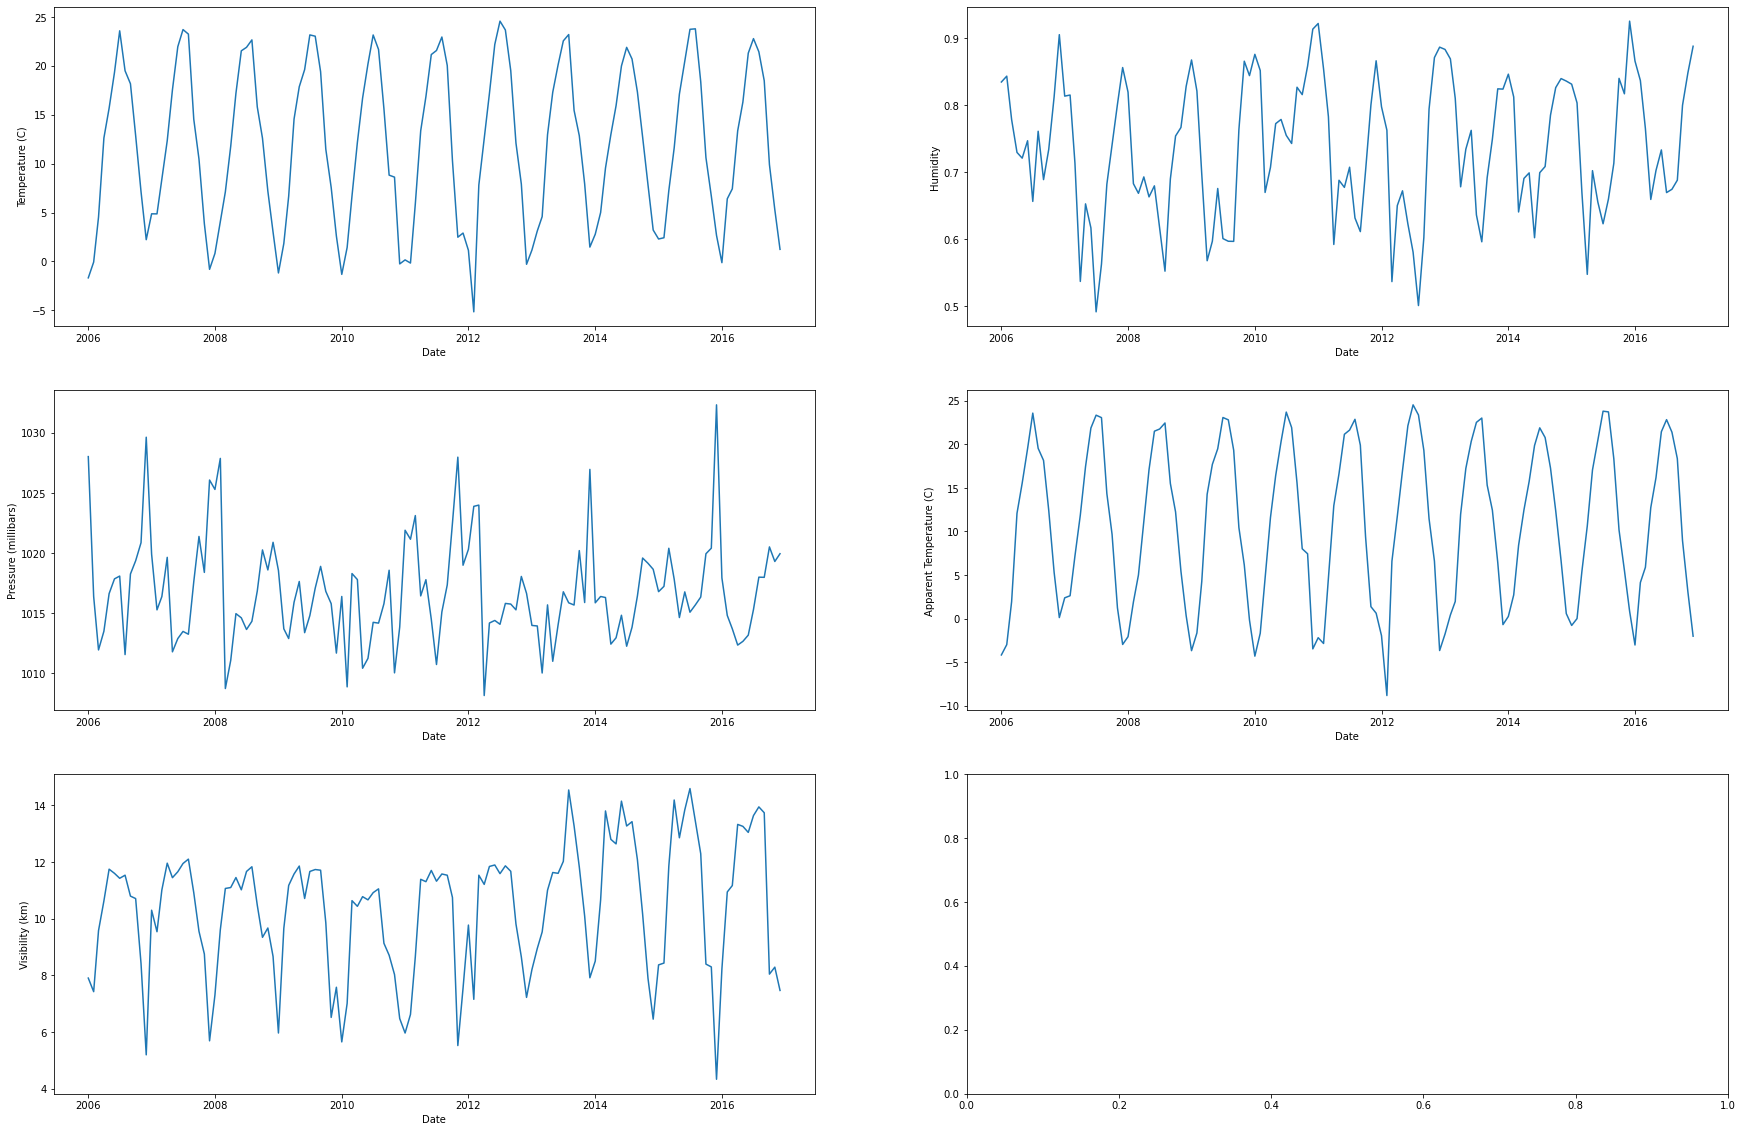

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(30,20))


#указываем X и Y
ax[0,0].plot(df_daily['Date'],df_daily['Temperature (C)'])
ax[0, 0].set(xlabel='Date', ylabel='Temperature (C)')



ax[0,1].plot(df_daily['Date'],df_daily['Humidity'])
ax[0, 1].set(xlabel='Date', ylabel='Humidity')

ax[1,0].plot(df_daily['Date'],df_daily['Pressure (millibars)'])
ax[1,0].set(xlabel='Date', ylabel='Pressure (millibars)')

ax[1,1].plot(df_daily['Date'],df_daily['Apparent Temperature (C)'])
ax[1,1].set(xlabel='Date', ylabel='Apparent Temperature (C)')

ax[2,0].plot(df_daily['Date'],df_daily['Visibility (km)'])
ax[2,0].set(xlabel='Date', ylabel='Visibility (km)')

Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not
<li><i> H0: The time series is non-stationary </i>
   <li><i> H1: The time series is stationary </i> 

In [17]:
for i in ['Temperature (C)','Humidity','Pressure (millibars)','Apparent Temperature (C)','Visibility (km)']:
    result = smt.stattools.adfuller(df_daily[i])
    if result[1] <= 0.05:
        print('Reject the null hypothesis for %s, the time series is stationary\n Augmented Dickey-Fuller test :\nStatistic value = %5f\np-value = %5f' % (i, result[0], result[1]))
    else:
        print("Don't reject the null hypothesis for %s, the time series is non-stationary\n Augmented Dickey-Fuller test :\nStatistic value = %5f\np-value = %5f" % (i, result[0], result[1]))

Don't reject the null hypothesis for Temperature (C), the time series is non-stationary
 Augmented Dickey-Fuller test :
Statistic value = -2.427507
p-value = 0.134123
Reject the null hypothesis for Humidity, the time series is stationary
 Augmented Dickey-Fuller test :
Statistic value = -3.138829
p-value = 0.023810
Reject the null hypothesis for Pressure (millibars), the time series is stationary
 Augmented Dickey-Fuller test :
Statistic value = -6.268565
p-value = 0.000000
Reject the null hypothesis for Apparent Temperature (C), the time series is stationary
 Augmented Dickey-Fuller test :
Statistic value = -3.089242
p-value = 0.027360
Don't reject the null hypothesis for Visibility (km), the time series is non-stationary
 Augmented Dickey-Fuller test :
Statistic value = -0.998010
p-value = 0.753989


## Transformation data 

Season-based differentition for the 12 months - 365 day step shift

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_daily.index=pd.date_range(freq="m",start=df_daily["Date"][0],periods=len(df_daily["Date"]))
result = seasonal_decompose((df_daily['Temperature (C)'].dropna()), model='additive')

In [20]:
df_daily

,Date,Temperature (C),Humidity,Pressure (millibars),Apparent Temperature (C),Visibility (km)
2006-01-31,2006-01-01,-1.674283,0.834651,1028.024489,-4.170818,7.900988
2006-02-28,2006-02-01,-0.061285,0.843393,1016.386830,-2.986136,7.421214
2006-03-31,2006-03-01,4.533468,0.778654,1011.941642,1.940272,9.577225
2006-04-30,2006-04-01,12.625872,0.729528,1013.496472,12.083819,10.626760
2006-05-31,2006-05-01,15.665315,0.720968,1016.624651,15.555600,11.748066
...,...,...,...,...,...,...
2016-08-31,2016-08-01,21.433998,0.674516,1017.995094,21.396797,13.947772
2016-09-30,2016-09-01,18.478465,0.688069,1017.981389,18.366373,13.740948
2016-10-31,2016-10-01,9.904579,0.799973,1020.512564,8.938837,8.041032
2016-11-30,2016-11-01,5.289074,0.848444,1019.300389,3.056674,8.287207


<Figure size 1440x576 with 0 Axes>

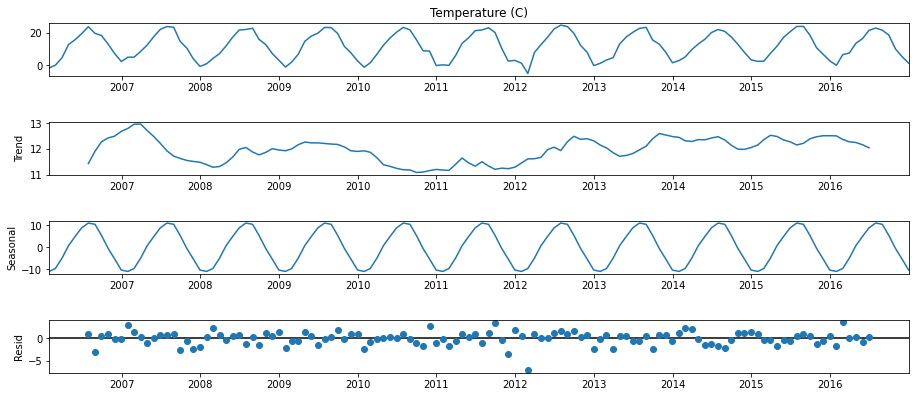

In [23]:
plt.figure(figsize=(20,8))
fig=result.plot()
fig.set_figheight(6)
fig.set_figwidth(14)

plt.show()

<Figure size 1440x576 with 0 Axes>

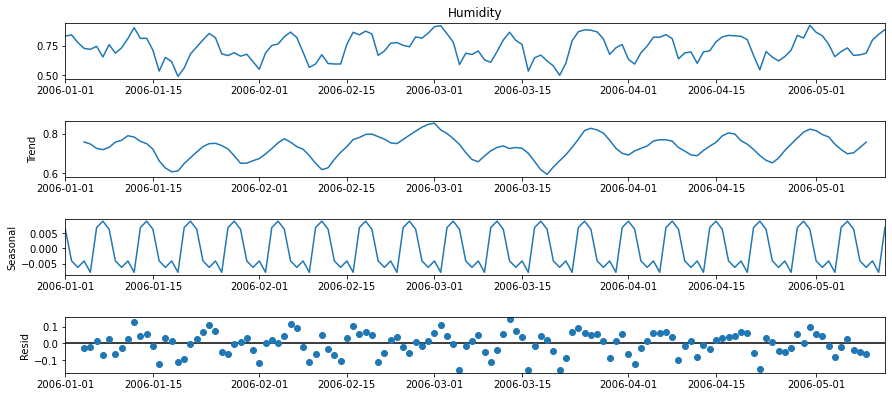

In [25]:

df_daily.index=pd.date_range(freq="d",start=df_daily["Date"][0],periods=len(df_daily["Date"]))
result = seasonal_decompose((df_daily['Humidity'].dropna()), model='additive')
plt.figure(figsize=(20,8))
fig=result.plot()
fig.set_figheight(6)
fig.set_figwidth(14)

plt.show()

<Figure size 1440x576 with 0 Axes>

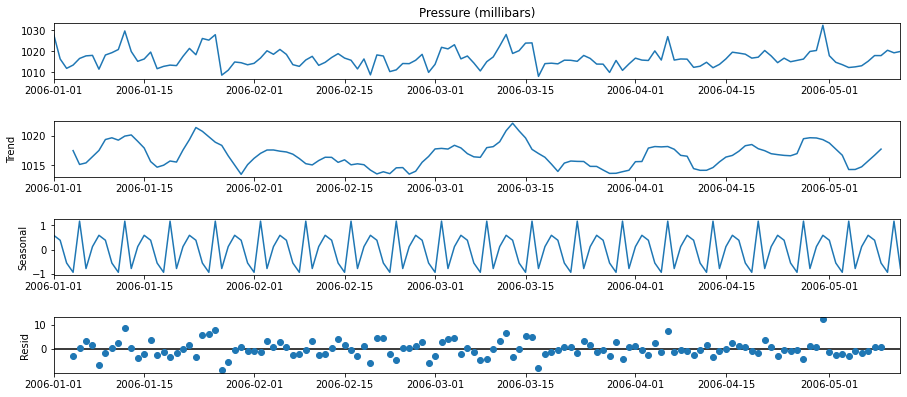

In [26]:

df_daily.index=pd.date_range(freq="d",start=df_daily["Date"][0],periods=len(df_daily["Date"]))
result = seasonal_decompose((df_daily['Pressure (millibars)'].dropna()), model='additive')
plt.figure(figsize=(20,8))
fig=result.plot()
fig.set_figheight(6)
fig.set_figwidth(14)

plt.show()

<Figure size 1440x576 with 0 Axes>

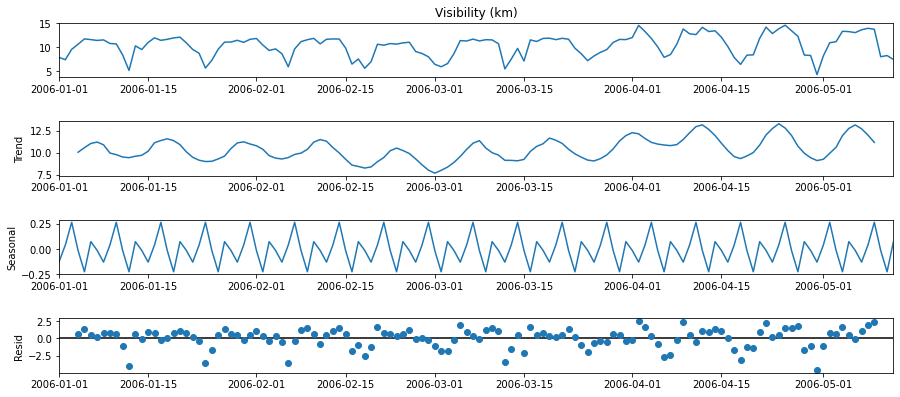

In [163]:

df_daily.index=pd.date_range(freq="d",start=df_daily["Date"][0],periods=len(df_daily["Date"]))
result = seasonal_decompose((df_daily['Visibility (km)'].dropna()), model='additive')
plt.figure(figsize=(20,8))
fig=result.plot()
fig.set_figheight(6)
fig.set_figwidth(14)

plt.show()

<Figure size 1440x576 with 0 Axes>

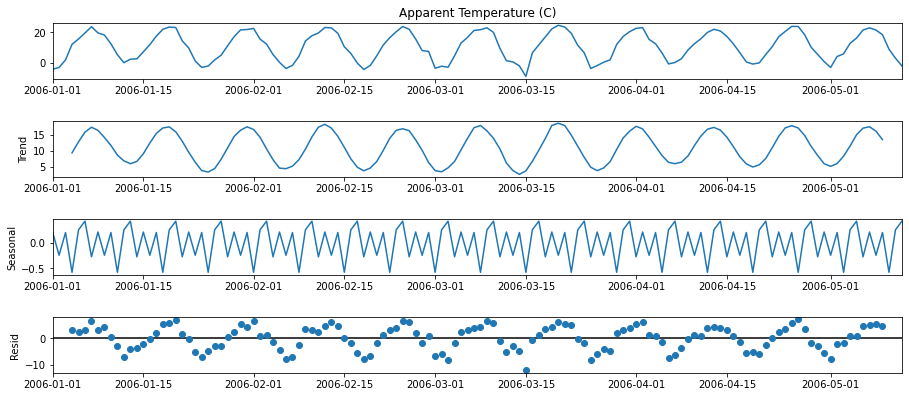

In [28]:

df_daily.index=pd.date_range(freq="d",start=df_daily["Date"][0],periods=len(df_daily["Date"]))
result = seasonal_decompose((df_daily['Apparent Temperature (C)'].dropna()), model='additive')
plt.figure(figsize=(20,8))
fig=result.plot()
fig.set_figheight(6)
fig.set_figwidth(14)

plt.show()

In [29]:
 r=smt.stattools.adfuller(df['Temperature (C)'])

In [31]:
df_daily['Temperature (C)_diff'] = df_daily['Temperature (C)'] - df_daily['Temperature (C)'].shift(12)
df_daily['Temperature (C)_diff'] =  df_daily['Temperature (C)_diff'] -  df_daily['Temperature (C)_diff'].shift(1)
df_daily['Apparent Temperature (C)_diff'] = df_daily['Apparent Temperature (C)'] - df_daily['Apparent Temperature (C)'].shift(12)
df_daily['Apparent Temperature (C)_diff'] =  df_daily['Apparent Temperature (C)_diff'] -  df_daily['Apparent Temperature (C)_diff'].shift(1) 
df_daily['Humidity_diff'] = df_daily['Humidity'] - df_daily['Humidity'].shift(12)   
df_daily['Humidity_diff'] = df_daily['Humidity_diff'] - df_daily['Humidity_diff'].shift(1)  
df_daily['Visibility (km)_diff'] = df_daily['Visibility (km)'] - df_daily['Visibility (km)'].shift(12)  
df_daily['Visibility (km)_diff'] = df_daily['Visibility (km)_diff'] - df_daily['Visibility (km)_diff'].shift(1)   
df_daily['Pressure (millibars)_diff'] = df_daily['Pressure (millibars)'] - df_daily['Pressure (millibars)'].shift(12)
df_daily['Pressure (millibars)_diff'] = df_daily['Pressure (millibars)_diff'] - df_daily['Pressure (millibars)_diff'].shift(1)   

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Visibility (km)_diff')]

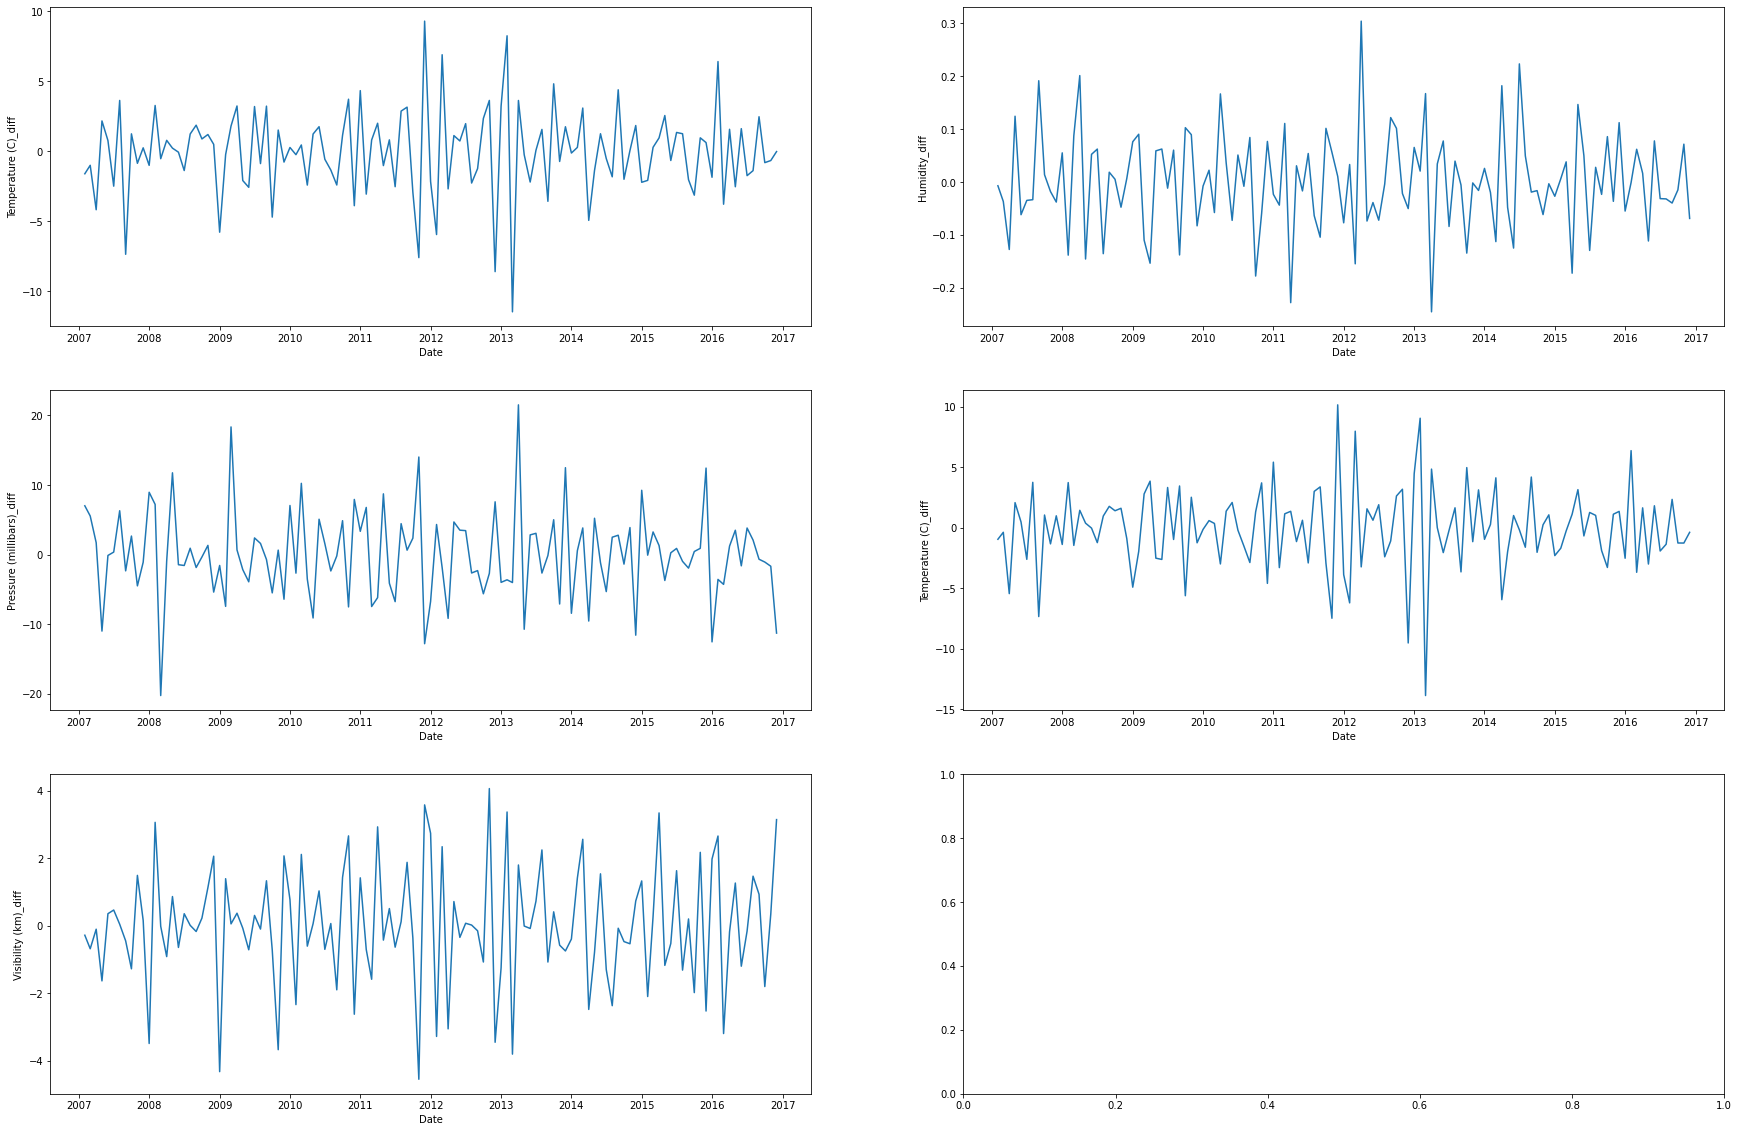

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(30,20))



#указываем X и Y
ax[0,0].plot(df_daily['Date'],df_daily['Temperature (C)_diff'])
ax[0, 0].set(xlabel='Date', ylabel='Temperature (C)_diff')

ax[0,1].plot(df_daily['Date'],df_daily['Humidity_diff'])
ax[0,1].set(xlabel='Date', ylabel='Humidity_diff')

ax[1,0].plot(df_daily['Date'],df_daily['Pressure (millibars)_diff'])
ax[1,0].set(xlabel='Date', ylabel='Pressure (millibars)_diff')

ax[1,1].plot(df_daily['Date'],df_daily['Apparent Temperature (C)_diff'])
ax[1,1].set(xlabel='Date', ylabel='Temperature (C)_diff')

ax[2,0].plot(df_daily['Date'],df_daily['Visibility (km)_diff'])
ax[2,0].set(xlabel='Date', ylabel='Visibility (km)_diff')

In [33]:
for i in ['Temperature (C)_diff','Humidity_diff','Pressure (millibars)_diff','Apparent Temperature (C)_diff','Visibility (km)_diff']:
    result = smt.stattools.adfuller(df_daily[i].dropna())
    if result[1] <= 0.05:
        print('Reject the null hypothesis for %s, the time series is stationary\n Augmented Dickey-Fuller test :\nStatistic value = %5f\np-value = %5f' % (i, result[0], result[1]))
    else:
        print("Don't reject the null hypothesis for %s, the time series is non-stationary\n Augmented Dickey-Fuller test :\nStatistic value = %5f\np-value = %5f" % (i, result[0], result[1]))

Reject the null hypothesis for Temperature (C)_diff, the time series is stationary
 Augmented Dickey-Fuller test :
Statistic value = -5.094486
p-value = 0.000014
Reject the null hypothesis for Humidity_diff, the time series is stationary
 Augmented Dickey-Fuller test :
Statistic value = -4.646026
p-value = 0.000106
Reject the null hypothesis for Pressure (millibars)_diff, the time series is stationary
 Augmented Dickey-Fuller test :
Statistic value = -3.413524
p-value = 0.010506
Reject the null hypothesis for Apparent Temperature (C)_diff, the time series is stationary
 Augmented Dickey-Fuller test :
Statistic value = -5.091636
p-value = 0.000015
Reject the null hypothesis for Visibility (km)_diff, the time series is stationary
 Augmented Dickey-Fuller test :
Statistic value = -4.021531
p-value = 0.001302


In [34]:
print('Augmented Dickey-Fuller test %s:\nStatistic value = %5f\np-value = %5f' % ('i', r[0], r[1]))

Augmented Dickey-Fuller test i:
Statistic value = -10.140083
p-value = 0.000000


# Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets.

Autocorrelation (ACF) is the correlation between two observations at different points in a time series
<br>The partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags

Populating the interactive namespace from numpy and matplotlib


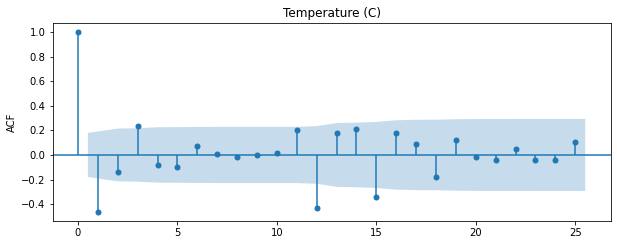

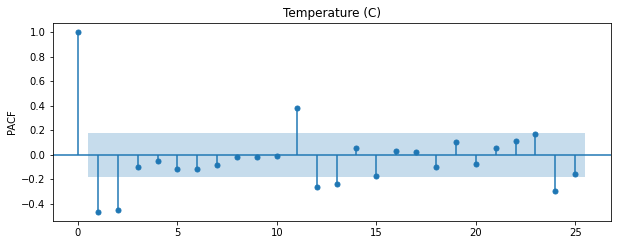

In [249]:
%pylab inline

plt.figure(figsize=(10,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_daily['Temperature (C)_diff'].dropna().values.squeeze(), lags=25, ax=ax)
plt.ylabel('ACF')
plt.title('Temperature (C)')
pylab.show()

plt.figure(figsize=(10,8))

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_daily['Temperature (C)_diff'].dropna().values.squeeze(), lags=25, ax=ax, title=None)
plt.ylabel('PACF')
plt.title('Temperature (C)')
pylab.show()

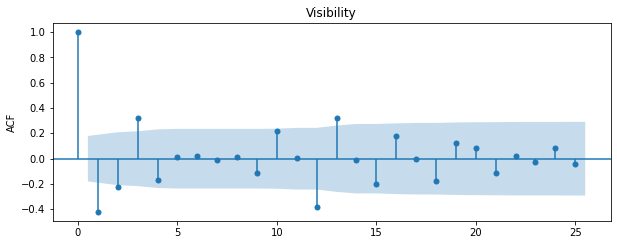

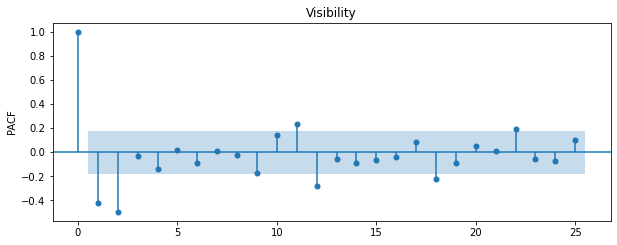

In [250]:
plt.figure(figsize=(10,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_daily['Visibility (km)_diff'].dropna().values.squeeze(), lags=25, ax=ax)
plt.ylabel('ACF')
plt.title('Visibility')
pylab.show()

plt.figure(figsize=(10,8))

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_daily['Visibility (km)_diff'].dropna().values.squeeze(), lags=25, ax=ax, title=None)
plt.ylabel('PACF')
plt.title('Visibility')
pylab.show()

Text(0.5, 1.0, 'Temperature (C)')

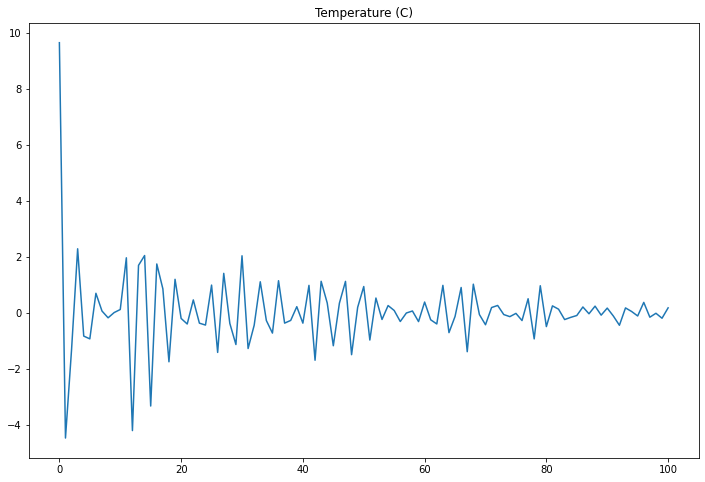

In [120]:
#autocovariation 
plt.figure(figsize=(12,8))
plt.plot(tsa.stattools.acovf(df_daily['Temperature (C)_diff'].dropna(),nlag = 100, fft = False))
plt.title('Temperature (C)')

Text(0.5, 1.0, 'Visibility')

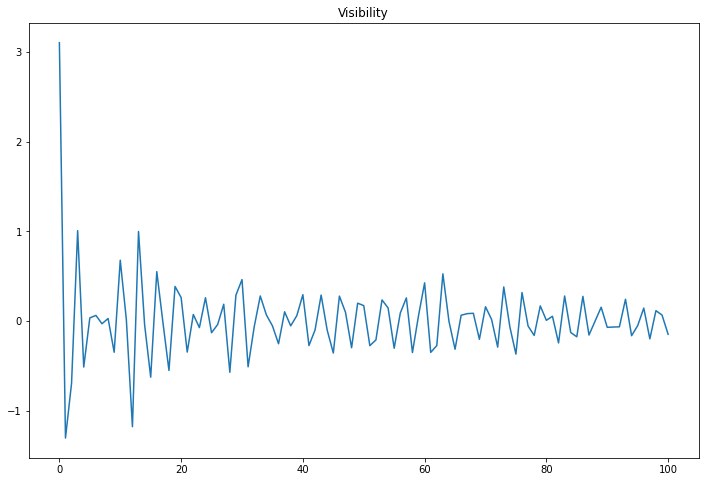

In [119]:

plt.figure(figsize=(12,8))
plt.plot(tsa.stattools.acovf(df_daily['Visibility (km)_diff'].dropna(),nlag = 100, fft = False))
plt.title('Visibility')

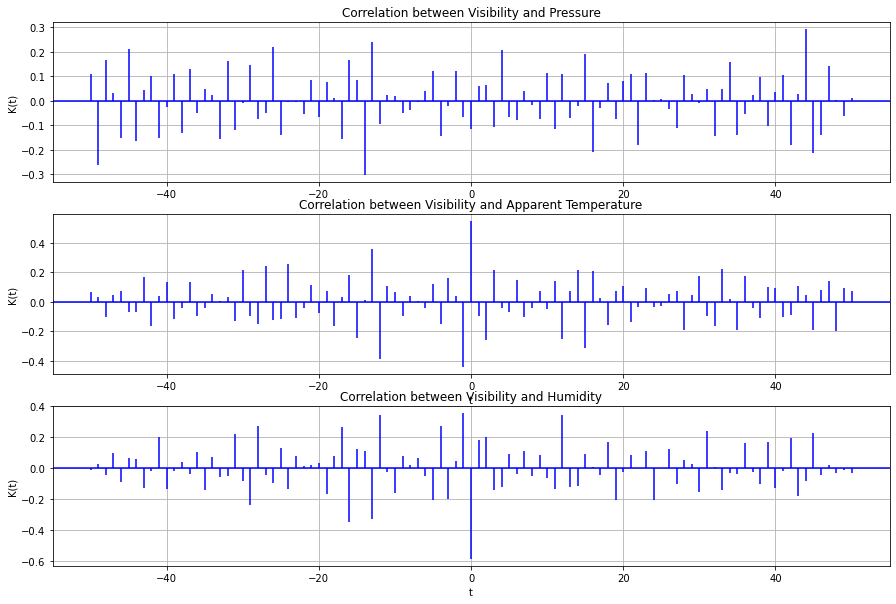

In [121]:
#Plot graph
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(311)
# cross correlation using
# xcorr() function
ax1.xcorr(df_daily['Visibility (km)_diff'].dropna(), df_daily['Pressure (millibars)_diff'].dropna(), usevlines=True,
          maxlags=50, normed=True, color='blue')
ax1.set_ylabel('K(t)')
ax1.set_title('Correlation between Visibility and Pressure')  
ax1.grid()

ax2 = fig.add_subplot(312)
ax2.xcorr(df_daily['Visibility (km)_diff'].dropna(),df_daily['Apparent Temperature (C)_diff'].dropna(), usevlines=True,
          maxlags=50, normed=True, color='blue')
ax2.set_ylabel('K(t)')
ax2.set_xlabel('t')
ax2.set_title('Correlation between Visibility and Apparent Temperature')  
ax2.grid()
 
ax3 = fig.add_subplot(313)
ax3.xcorr(df_daily['Visibility (km)_diff'].dropna(),df_daily['Humidity_diff'].dropna(), usevlines=True,
          maxlags=50, normed=True, color='blue')
ax3.set_ylabel('K(t)')
ax3.set_xlabel('t')
ax3.set_title('Correlation between Visibility and Humidity')  
ax3.grid()
 
# show final plotted graph
plt.show()

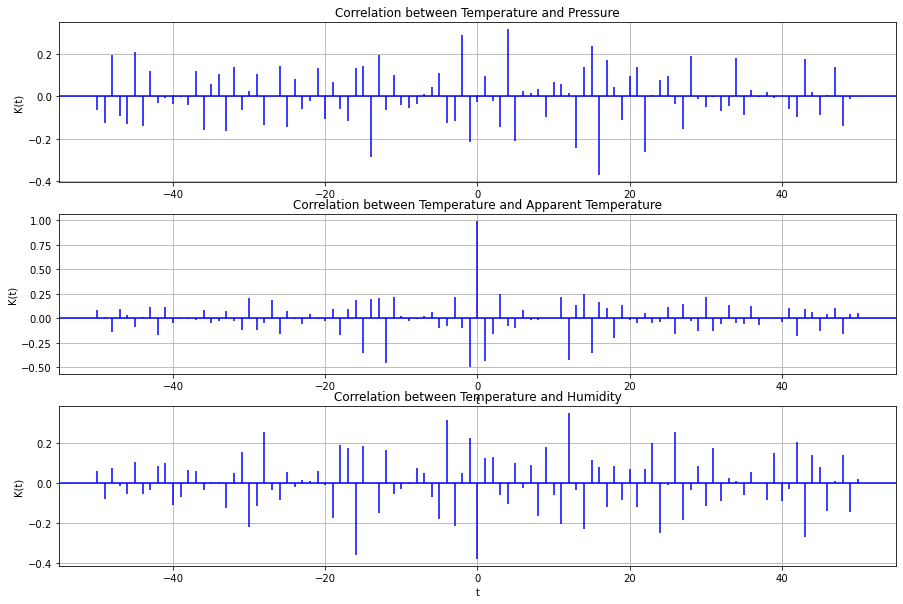

In [124]:
#Plot graph
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(311)
# cross correlation using
# xcorr() function
ax1.xcorr(df_daily['Temperature (C)_diff'].dropna(), df_daily['Pressure (millibars)_diff'].dropna(), usevlines=True,
          maxlags=50, normed=True, color='blue')
ax1.set_ylabel('K(t)')
ax1.set_title('Correlation between Temperature and Pressure')  
ax1.grid()

ax2 = fig.add_subplot(312)
ax2.xcorr(df_daily['Temperature (C)_diff'].dropna(),df_daily['Apparent Temperature (C)_diff'].dropna(), usevlines=True,
          maxlags=50, normed=True, color='blue')
ax2.set_ylabel('K(t)')
ax2.set_xlabel('t')
ax2.set_title('Correlation between Temperature and Apparent Temperature')  
ax2.grid()

ax3 = fig.add_subplot(313)
ax3.xcorr(df_daily['Temperature (C)_diff'].dropna(),df_daily['Humidity_diff'].dropna(), usevlines=True,
          maxlags=50, normed=True, color='blue')
ax3.set_ylabel('K(t)')
ax3.set_xlabel('t')
ax3.set_title('Correlation between Temperature and Humidity')  
ax3.grid()
 
 

# Filter high frequencies (noise) with chosen 2 filters for target variables.

In [132]:
#pip install fedot==0.4.1

In [133]:
import fedot

In [134]:
# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

In [135]:
# Convert into numpy array first
time_series = np.array(df_daily['Temperature (C)_diff'])
time_series2 = np.array(df_daily['Visibility (km)_diff'])
# Define task - time series forecasting
# and forecast horizon 
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=25))

input_data_1 = InputData(idx=np.arange(0, len(time_series)),
                       features=time_series, target=time_series,
                       task=task, data_type=DataTypesEnum.ts)
input_data_2 = InputData(idx=np.arange(0, len(time_series2)),
                       features=time_series2, target=time_series2,
                       task=task, data_type=DataTypesEnum.ts)

## Rolling mean window smoothing

In [136]:
smoothing_node = PrimaryNode('smoothing') 
smoothing_node.custom_params = {'window_size': 10}

def node_fit_predict(node, input_data):
    """ Fit node and make prediction """
    node.fit(input_data)
    smoothed_output = node.predict(input_data)
    return smoothed_output

smoothed_output_1 = node_fit_predict(smoothing_node, input_data_1)
smoothed_output_2 = node_fit_predict(smoothing_node, input_data_2)

## Gaussian filter

In [140]:
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 2}

smoothed_gaussian_1 = node_fit_predict(gaussian_node, input_data_1)
smoothed_gaussian_2 = node_fit_predict(gaussian_node, input_data_2)

In [138]:
PrimaryNode('bartlett_filter') 

bartlett_filter

## Plot

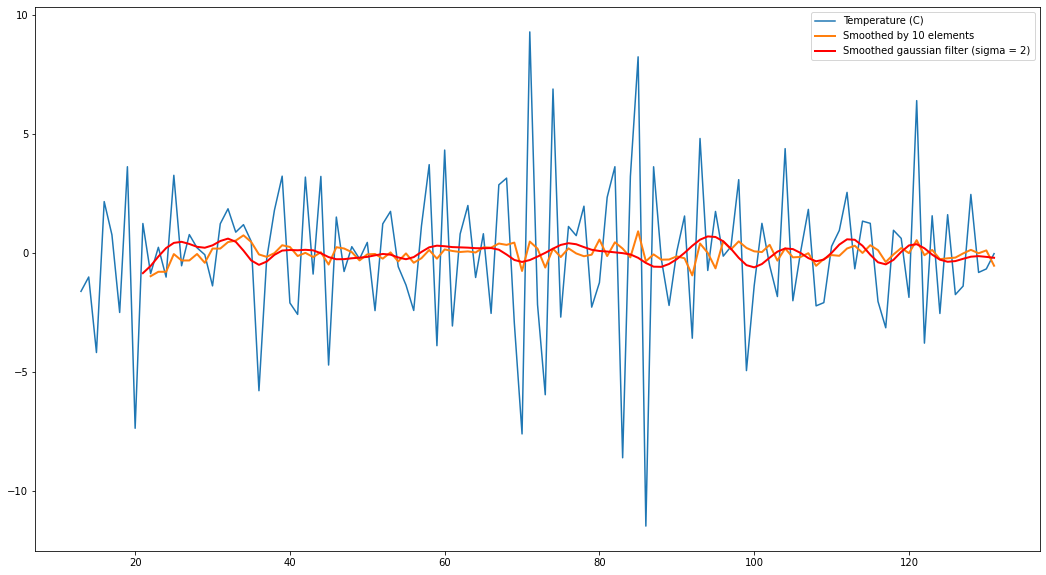

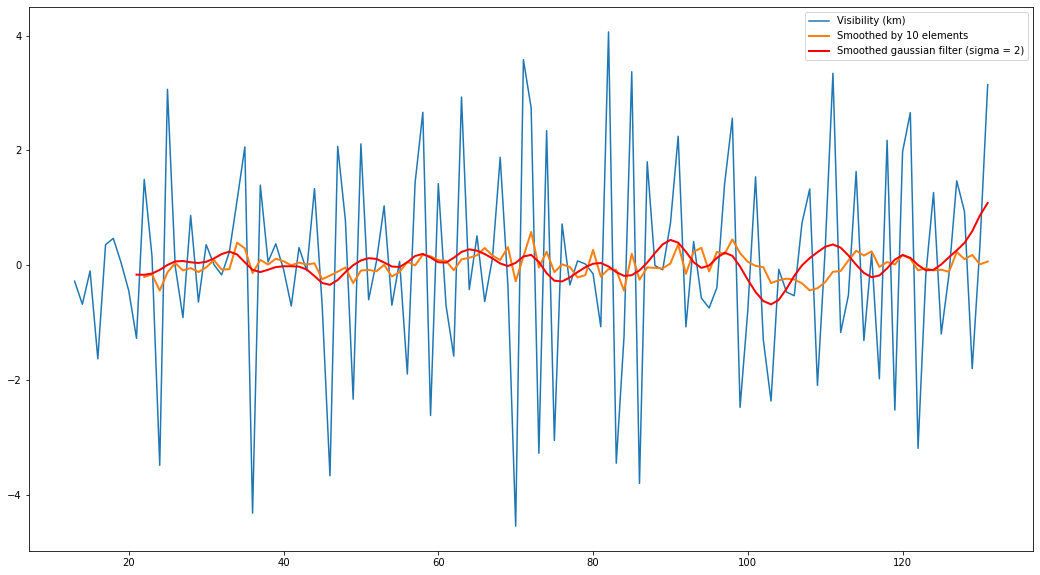

In [277]:

plt.figure(figsize=(18, 10))
plt.plot(input_data_1.idx, input_data_1.target, label='Temperature (C)')
plt.plot(smoothed_output_1.idx, smoothed_output_1.predict, label='Smoothed by 10 elements', linewidth=2)
plt.plot(smoothed_gaussian_1.idx, smoothed_gaussian_1.predict, label='Smoothed gaussian filter (sigma = 2)', linewidth=2, c='red')
plt.legend()
plt.show()


plt.figure(figsize=(18, 10))
plt.plot(input_data_2.idx, input_data_2.target, label='Visibility (km)')
plt.plot(smoothed_output_2.idx, smoothed_output_2.predict, label='Smoothed by 10 elements', linewidth=2)
plt.plot(smoothed_gaussian_2.idx, smoothed_gaussian_2.predict, label='Smoothed gaussian filter (sigma = 2)', linewidth=2, c='red')
plt.legend()
plt.show()

# Estimate spectral density function for with and without filtering.

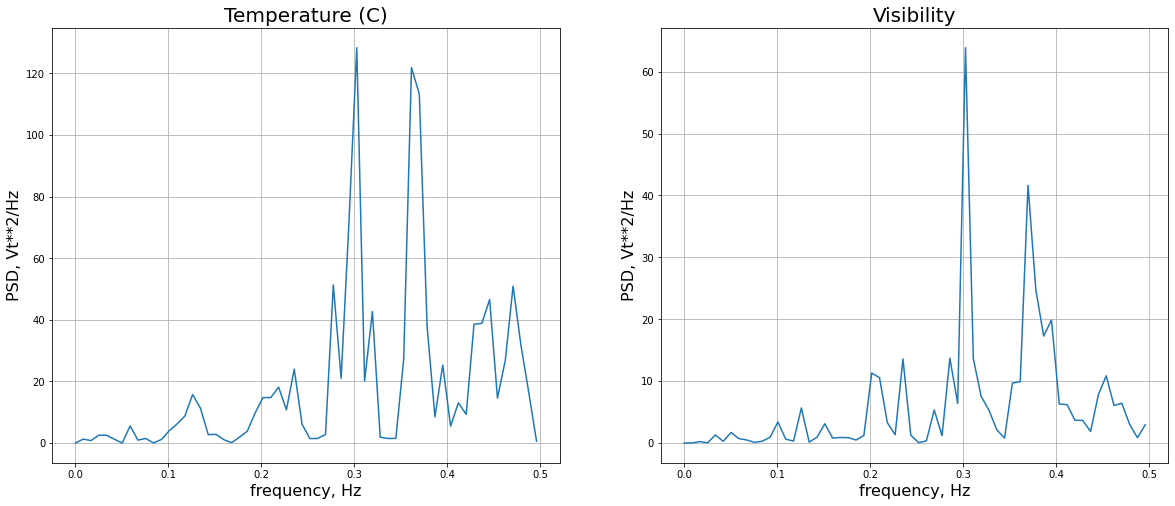

In [142]:
#Without filtering
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

f, p = scipy.signal.periodogram(x = df_daily['Temperature (C)_diff'].dropna(),fs=1,window=None)
ax[0].plot(f, p)
ax[0].set_xlabel('frequency, Hz',fontsize=16)
ax[0].set_ylabel('PSD, Vt**2/Hz',fontsize=16)
ax[0].set_title('Temperature (C)',fontsize=20)
ax[0].grid()

f, p = scipy.signal.periodogram(x = df_daily['Visibility (km)_diff'].dropna(),fs=1,window=None)
ax[1].plot(f, p)
ax[1].set_xlabel('frequency, Hz',fontsize=16)
ax[1].set_ylabel('PSD, Vt**2/Hz',fontsize=16)
ax[1].set_title('Visibility',fontsize=20)
ax[1].grid()



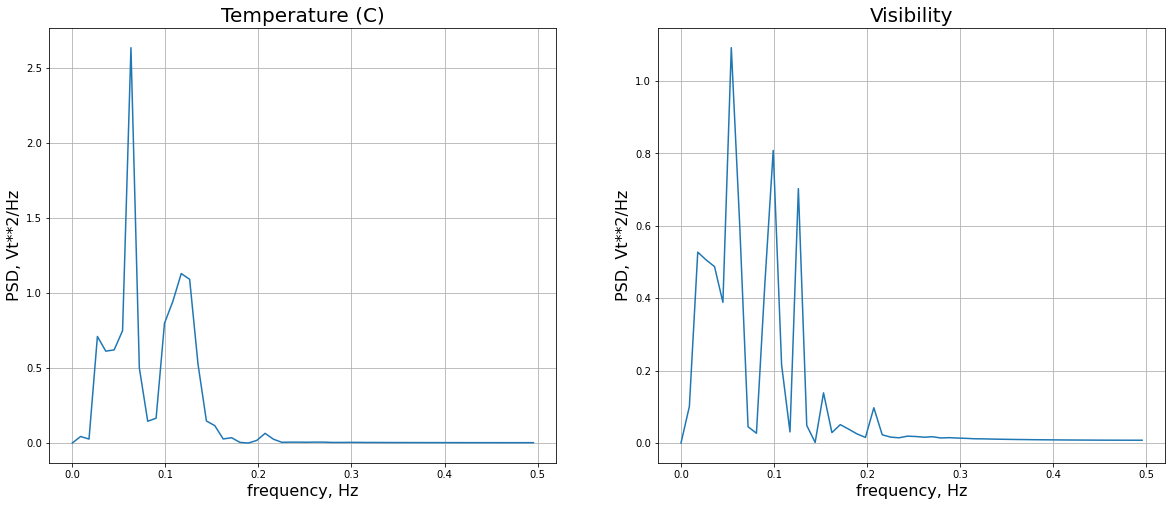

In [143]:
#Gaussian filter
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

f, p = scipy.signal.periodogram(x = smoothed_gaussian_1.predict[~numpy.isnan(smoothed_gaussian_1.predict)],fs=1,window=None)
ax[0].plot(f, p)
ax[0].set_xlabel('frequency, Hz',fontsize=16)
ax[0].set_ylabel('PSD, Vt**2/Hz',fontsize=16)
ax[0].set_title('Temperature (C)',fontsize=20)
ax[0].grid()

f, p = scipy.signal.periodogram(x = smoothed_gaussian_2.predict[~numpy.isnan(smoothed_gaussian_2.predict)],fs=1,window=None)
ax[1].plot(f, p)
ax[1].set_xlabel('frequency, Hz',fontsize=16)
ax[1].set_ylabel('PSD, Vt**2/Hz',fontsize=16)
ax[1].set_title('Visibility',fontsize=20)
ax[1].grid()

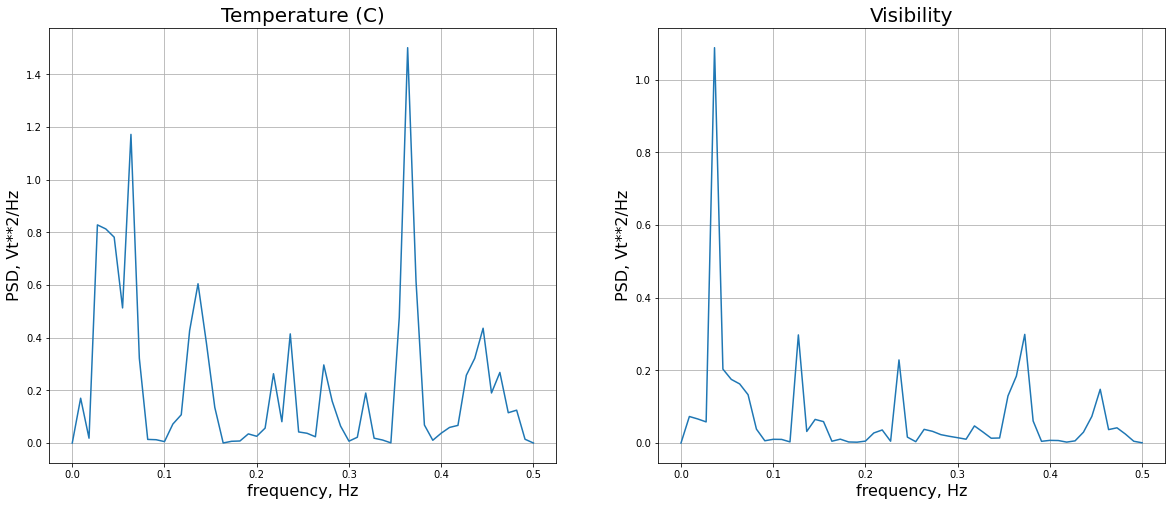

In [144]:
#Smoothing filter
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

f, p = scipy.signal.periodogram(x = smoothed_output_1.predict[~numpy.isnan(smoothed_output_1.predict)],fs=1,window=None)
ax[0].plot(f, p)
ax[0].set_xlabel('frequency, Hz',fontsize=16)
ax[0].set_ylabel('PSD, Vt**2/Hz',fontsize=16)
ax[0].set_title('Temperature (C)',fontsize=20)
ax[0].grid()

f, p = scipy.signal.periodogram(x = smoothed_output_2.predict[~numpy.isnan(smoothed_output_2.predict)],fs=1,window=None)
ax[1].plot(f, p)
ax[1].set_xlabel('frequency, Hz',fontsize=16)
ax[1].set_ylabel('PSD, Vt**2/Hz',fontsize=16)
ax[1].set_title('Visibility',fontsize=20)
ax[1].grid()


# Built auto-regression model filtered and non-filtered data. To analyze residual error and to define appropriate order of model.

## SARIMAX - Temperature (non-filtered)

In [356]:
from itertools import product

ps = range(0, 8)
d=1
qs = range(0, 8)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
print (u"Models to analyse by AIC:", len(parameters_list))

[(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (0, 2, 0, 0), (0, 2, 1, 0), (0, 3, 0, 0), (0, 3, 1, 0), (0, 4, 0, 0), (0, 4, 1, 0), (0, 5, 0, 0), (0, 5, 1, 0), (0, 6, 0, 0), (0, 6, 1, 0), (0, 7, 0, 0), (0, 7, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0), (1, 2, 0, 0), (1, 2, 1, 0), (1, 3, 0, 0), (1, 3, 1, 0), (1, 4, 0, 0), (1, 4, 1, 0), (1, 5, 0, 0), (1, 5, 1, 0), (1, 6, 0, 0), (1, 6, 1, 0), (1, 7, 0, 0), (1, 7, 1, 0), (2, 0, 0, 0), (2, 0, 1, 0), (2, 1, 0, 0), (2, 1, 1, 0), (2, 2, 0, 0), (2, 2, 1, 0), (2, 3, 0, 0), (2, 3, 1, 0), (2, 4, 0, 0), (2, 4, 1, 0), (2, 5, 0, 0), (2, 5, 1, 0), (2, 6, 0, 0), (2, 6, 1, 0), (2, 7, 0, 0), (2, 7, 1, 0), (3, 0, 0, 0), (3, 0, 1, 0), (3, 1, 0, 0), (3, 1, 1, 0), (3, 2, 0, 0), (3, 2, 1, 0), (3, 3, 0, 0), (3, 3, 1, 0), (3, 4, 0, 0), (3, 4, 1, 0), (3, 5, 0, 0), (3, 5, 1, 0), (3, 6, 0, 0), (3, 6, 1, 0), (3, 7, 0, 0), (3, 7, 1, 0), (4, 0, 0, 0), (4, 0, 1, 0), (4, 1, 0, 0), (4, 1, 1, 0), (4, 2, 0, 0), (4, 2, 1, 0), (4, 3, 0, 0), (4, 3

In [147]:
test_size=10
y_train=df_daily['Temperature (C)_diff'].dropna()[: -test_size]
y_test=df_daily['Temperature (C)_diff'].dropna()[-test_size :]

# ignore warnings 
results = []
best_aic = float("inf")

warnings.filterwarnings('ignore')
i=0
for param in parameters_list:
    print(i)
    i=i+1
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(y_train, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        print("error")
        continue 
    #except LinAlgError:
    #        continue
    aic = model.aic

    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [357]:
test_size=10
y_train=df_daily['Temperature (C)_diff'].dropna()[: -test_size]
y_test=df_daily['Temperature (C)_diff'].dropna()[-test_size :]


In [358]:
param =  (4, 6, 1, 0)
model=sm.tsa.statespace.SARIMAX(y_train, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=True).fit(disp=-1)

In [150]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
77   (4, 6, 1, 0)  531.799872
11   (0, 5, 1, 0)  532.028168
111  (6, 7, 1, 0)  532.687845
105  (6, 4, 1, 0)  532.754964
93   (5, 6, 1, 0)  532.961924


In [152]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                Temperature (C)_diff   No. Observations:                  109
Model:             SARIMAX(4, 1, 6)x(1, 1, [], 12)   Log Likelihood                -253.900
Date:                             Sun, 28 Nov 2021   AIC                            531.800
Time:                                     17:26:29   BIC                            562.572
Sample:                                 01-14-2006   HQIC                           544.238
                                      - 05-02-2006                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6657      0.165    -10.092      0.000      -1.989      -1.342
ar.L2         -1.9272      

Text(0.5, 0, 'Date')

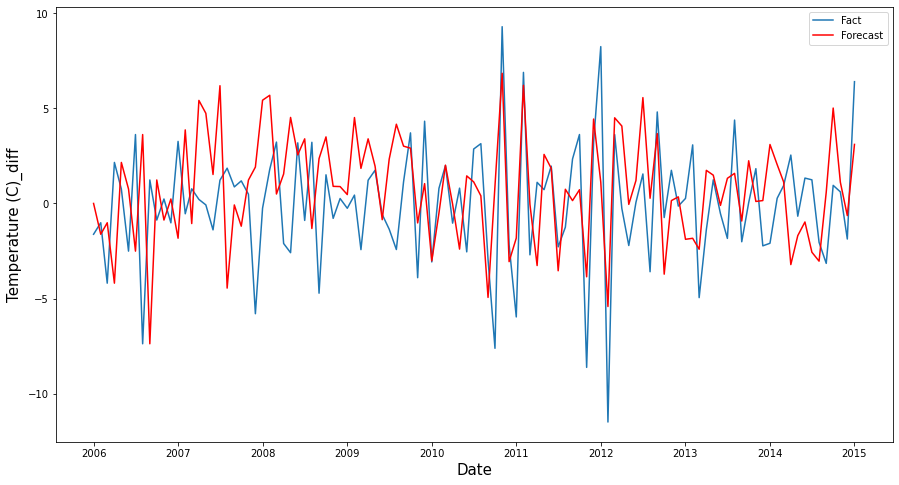

In [359]:

plt.figure(figsize=(15,8))
plt.plot(df_daily['Date'][:-23], y_train, label='Fact')
plt.plot(df_daily['Date'][:-23], model.predict(start=0, end=len(y_train)-1), color='r', label='Forecast')
plt.legend()
plt.ylabel('Temperature (C)_diff',fontsize=15)
plt.xlabel('Date',fontsize=15)



Text(0.5, 0, 'Date')

<Figure size 1440x720 with 0 Axes>

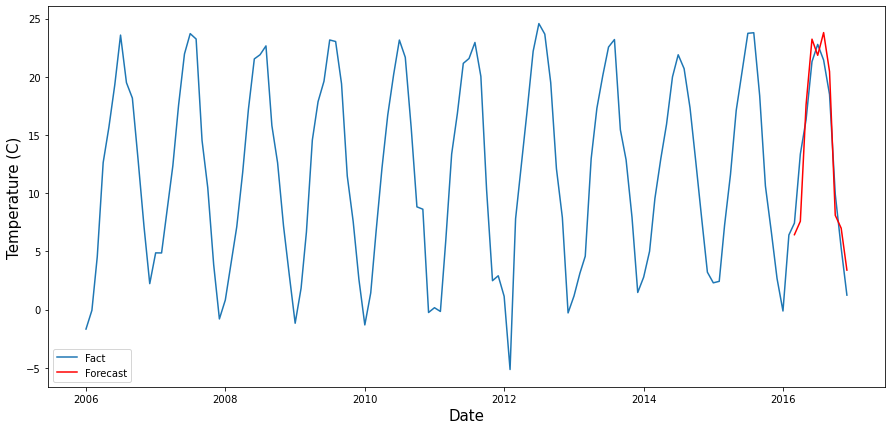

In [360]:
plt.figure(figsize=(20,10))
a= df_daily['Temperature (C)'].shift(1)
b=  df_daily['Temperature (C)'].shift(12)
forecast = model.forecast(steps=10)+b
plt.figure(figsize=(15,7))
plt.plot(df_daily['Date'], df_daily['Temperature (C)'].dropna(), label='Fact')  
plt.plot(df_daily['Date'], forecast, color='r', label='Forecast')
plt.legend()
plt.ylabel('Temperature (C)', fontsize=15);
plt.xlabel('Date',fontsize=15)


In [361]:
a= df_daily['Visibility (km)'].shift(1)
b=  df_daily['Visibility (km)'].shift(12)
forecast = (best_model_2.forecast(steps=10)+b).dropna()

test_accuracy = df_daily['Visibility (km)'][-10:]
print("MSE = ", mean_squared_error(test_accuracy, forecast ))
print("MAE = ", mean_absolute_error(test_accuracy, forecast ))
print("MAPE = ", round(np.mean(np.abs(test_accuracy-forecast) /test_accuracy)*100,3))

MSE =  2.170478410923117
MAE =  1.0956947538192279
MAPE =  10.636


In [364]:
a= df_daily['Temperature (C)'].shift(1)
b=  df_daily['Temperature (C)'].shift(12)
forecast = (model.forecast(steps=10)+b).dropna()
test_accuracy = df_daily['Temperature (C)'][-10:]
print("MSE = ", mean_squared_error(test_accuracy, forecast ))
print("MAE = ", mean_absolute_error(test_accuracy, forecast ))
print("MAPE = ", round(np.mean(np.abs((test_accuracy-forecast )/test_accuracy))*100,3))


MSE =  6.0792168442117775
MAE =  2.0909560635988935
MAPE =  32.32


In [350]:
model.forecast(steps=10)

array([-0.02184634, -0.20215245, -0.36752332, -0.51706759, -0.65244702,
       -0.72980531, -0.68432583, -0.50355633, -0.25477543, -0.03882457])

In [363]:

forecast = model.forecast(steps=10)
test_accuracy = df_daily['Temperature (C)_diff'][-10:]
print("MSE = ", mean_squared_error(test_accuracy, forecast ))
print("MAE = ", mean_absolute_error(test_accuracy, forecast ))
print("MAPE = ", round(np.mean(np.abs((test_accuracy-forecast )/test_accuracy))*100,3))
print("R^2 = ", r2_score(test_accuracy, forecast))

MSE =  5.718209291262307
MAE =  1.8108544588405144
MAPE =  339.104
R^2 =  -0.6237760277163171


Student test: p=0.028732
Dickey-Fuller test: p=0.0000000000000000000000228


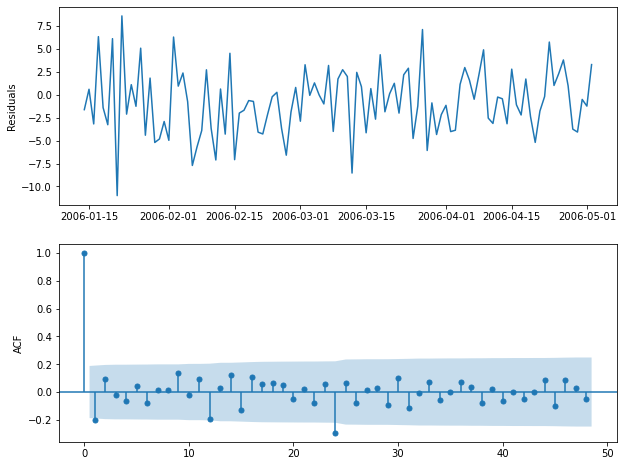

In [156]:
# residuals
plt.figure(figsize=(10,8))
ax = plt.subplot(211)
plt.plot(model.resid)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid.squeeze(), lags=48, ax=ax, title=None)
plt.ylabel('ACF')


print("Student test: p=%f" % scipy.stats.ttest_1samp(model.resid, 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(model.resid)[1])

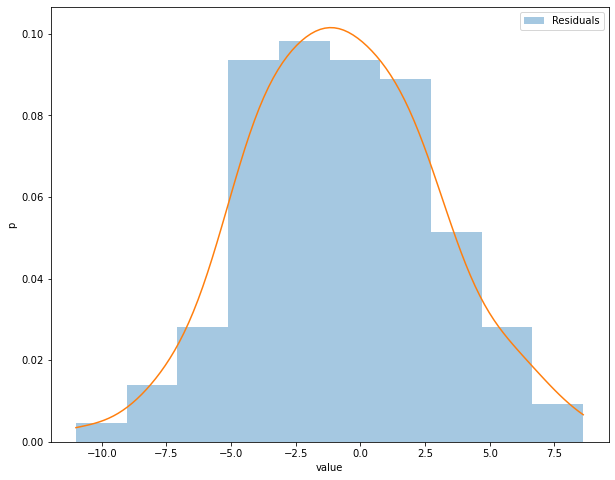

In [157]:
plt.figure(figsize=(10, 8))
d = model.resid
kernel = scipy.stats.gaussian_kde(d)
min_amount, max_amount = d.min(), d.max()
x = np.linspace(min_amount, max_amount, len(d))
kde_values = kernel(x)

sns.distplot(d, kde=False, norm_hist=True, label="Residuals")
plt.plot(x, kde_values)

plt.ylabel('p')
plt.xlabel('value')

plt.legend()
plt.show()

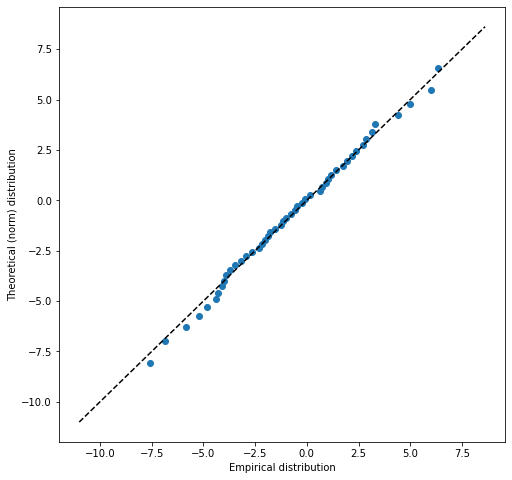

In [158]:
import scipy
params = scipy.stats.norm.fit(model.resid)
x = np.linspace( np.min(model.resid), np.max(model.resid))

percs = np.linspace(0, 100)
qn_first = np.percentile(model.resid, percs)
qn_gamma = scipy.stats.norm.ppf(percs / 100.0, *params)

# Building a quantile biplot
plt.figure(figsize=(8, 8))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

In [159]:
scipy.stats.shapiro( model.resid)

ShapiroResult(statistic=0.9959894418716431, pvalue=0.9893494248390198)

## SARIMAX - Visibility (non-filtered)

In [313]:
from itertools import product

ps = range(0, 8)
d=1
qs = range(0, 8)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
print (u"Models to analyse by AIC:", len(parameters_list))

[(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (0, 2, 0, 0), (0, 2, 1, 0), (0, 3, 0, 0), (0, 3, 1, 0), (0, 4, 0, 0), (0, 4, 1, 0), (0, 5, 0, 0), (0, 5, 1, 0), (0, 6, 0, 0), (0, 6, 1, 0), (0, 7, 0, 0), (0, 7, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0), (1, 2, 0, 0), (1, 2, 1, 0), (1, 3, 0, 0), (1, 3, 1, 0), (1, 4, 0, 0), (1, 4, 1, 0), (1, 5, 0, 0), (1, 5, 1, 0), (1, 6, 0, 0), (1, 6, 1, 0), (1, 7, 0, 0), (1, 7, 1, 0), (2, 0, 0, 0), (2, 0, 1, 0), (2, 1, 0, 0), (2, 1, 1, 0), (2, 2, 0, 0), (2, 2, 1, 0), (2, 3, 0, 0), (2, 3, 1, 0), (2, 4, 0, 0), (2, 4, 1, 0), (2, 5, 0, 0), (2, 5, 1, 0), (2, 6, 0, 0), (2, 6, 1, 0), (2, 7, 0, 0), (2, 7, 1, 0), (3, 0, 0, 0), (3, 0, 1, 0), (3, 1, 0, 0), (3, 1, 1, 0), (3, 2, 0, 0), (3, 2, 1, 0), (3, 3, 0, 0), (3, 3, 1, 0), (3, 4, 0, 0), (3, 4, 1, 0), (3, 5, 0, 0), (3, 5, 1, 0), (3, 6, 0, 0), (3, 6, 1, 0), (3, 7, 0, 0), (3, 7, 1, 0), (4, 0, 0, 0), (4, 0, 1, 0), (4, 1, 0, 0), (4, 1, 1, 0), (4, 2, 0, 0), (4, 2, 1, 0), (4, 3, 0, 0), (4, 3

In [314]:
test_size=10
y_train_2=df_daily['Visibility (km)_diff'].dropna()[: -test_size]
y_test_2=df_daily['Visibility (km)_diff'].dropna()[-test_size :]

In [315]:

# ignore warnings 
results_2 = []
best_aic_2 = float("inf")

warnings.filterwarnings('ignore')
i=0
for param in parameters_list:
    print(i)
    i=i+1
    #try except for the case of wrong parameters
    try:
        model_=sm.tsa.statespace.SARIMAX(y_train_2, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        print("error")
        continue 
    #except LinAlgError:
    #        continue
    aic = model_.aic

    # save best model, aic, parameters
    if (aic < best_aic_2):
        best_model_2 = model_
        best_aic_2 = aic
        best_param_2 = param
    results_2.append([param, model_.aic])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [316]:
result_table2 = pd.DataFrame(results_2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
35  (2, 1, 1, 0)  392.126572
11  (0, 5, 1, 0)  392.420372
71  (4, 3, 1, 0)  393.243150
27  (1, 5, 1, 0)  393.633152
37  (2, 2, 1, 0)  394.090674


In [160]:
print(best_model_2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                Visibility (km)_diff   No. Observations:                  109
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood                -191.063
Date:                             Sun, 28 Nov 2021   AIC                            392.127
Time:                                     17:27:43   BIC                            404.948
Sample:                                 01-14-2006   HQIC                           397.309
                                      - 05-02-2006                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6743      0.090     -7.532      0.000      -0.850      -0.499
ar.L2         -0.5178      

Text(0.5, 0, 'Date')

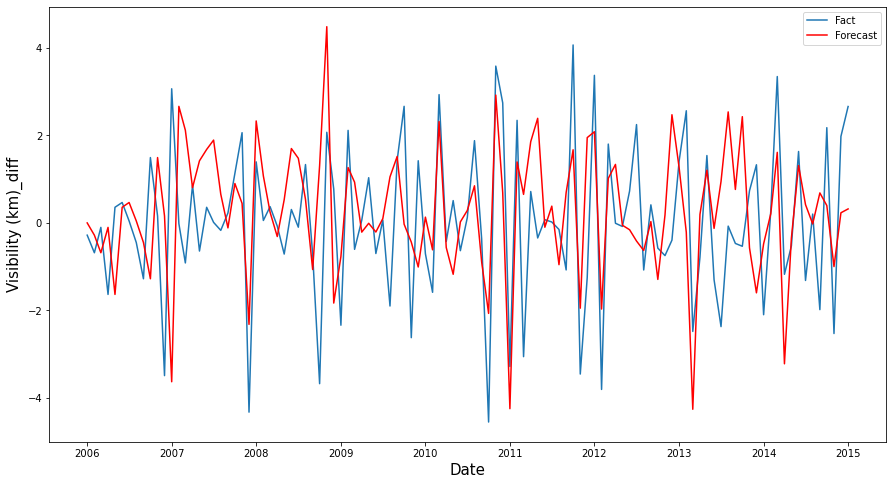

In [319]:
plt.figure(figsize=(15,8))
plt.plot(df_daily['Date'][:-23], y_train_2, label='Fact')
plt.plot(df_daily['Date'][:-23], best_model_2.predict(start=0, end=len(y_train_2)-1), color='r', label='Forecast')
plt.legend()
plt.ylabel('Visibility (km)_diff',fontsize=15)
plt.xlabel('Date',fontsize=15)

In [343]:
a= df_daily['Visibility (km)'].shift(1)
b=  df_daily['Visibility (km)'].shift(12)
forecast = (best_model_2.forecast(steps=10)+b).dropna()

test_accuracy = df_daily['Visibility (km)'][-10:]
print("MSE = ", mean_squared_error(test_accuracy, forecast ))
print("MAE = ", mean_absolute_error(test_accuracy, forecast ))
print("MAPE = ", round(np.mean(np.abs(test_accuracy-forecast) /test_accuracy)*100,3))


MSE =  2.170478410923117
MAE =  1.0956947538192279
MAPE =  10.636


In [344]:

forecast = (best_model_2.forecast(steps=10)).dropna()

test_accuracy = df_daily['Visibility (km)_diff'][-10:]
print("MSE = ", mean_squared_error(test_accuracy, forecast ))
print("MAE = ", mean_absolute_error(test_accuracy, forecast ))
print("MAPE = ", round(np.mean(np.abs(test_accuracy-forecast) /test_accuracy)*100,3))

MSE =  3.397699674487781
MAE =  1.4078877288588747
MAPE =  24.474


Text(0.5, 0, 'Date')

<Figure size 1440x720 with 0 Axes>

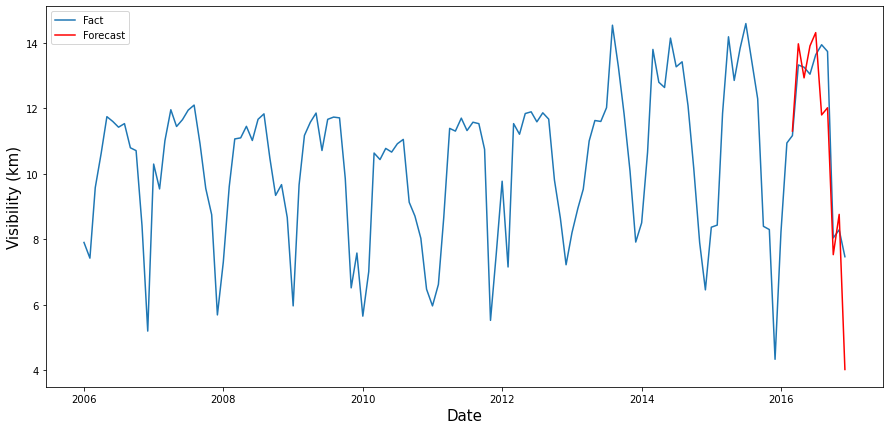

In [320]:
plt.figure(figsize=(20,10))
a= df_daily['Visibility (km)'].shift(1)
b=  df_daily['Visibility (km)'].shift(12)
forecast = best_model_2.forecast(steps=10)+b
plt.figure(figsize=(15,7))
plt.plot(df_daily['Date'], df_daily['Visibility (km)'].dropna(), label='Fact')  
plt.plot(df_daily['Date'], forecast, color='r', label='Forecast')
plt.legend()
plt.ylabel('Visibility (km)', fontsize=15);
plt.xlabel('Date',fontsize=15)




In [306]:
a= df_daily['Visibility (km)'].shift(1)
b=  df_daily['Visibility (km)'].shift(12)
forecast = (best_model_2.forecast(steps=10)+b).dropna()
test_accuracy = df_daily['Visibility (km)'][-10:]
print("MSE = ", mean_squared_error(test_accuracy, forecast ))
print("MAE = ", mean_absolute_error(test_accuracy, forecast ))
print("MAPE = ", round(np.mean(np.abs((test_accuracy-forecast) /test_accuracy))*100,3))
print("R^2 = ", r2_score(test_accuracy, forecast))


MSE =  2.170478410923117
MAE =  1.0956947538192279
MAPE =  10.636
R^2 =  0.655610306448769


Student test: p=0.141332
Dickey-Fuller test: p=0.0000000000000000000016872


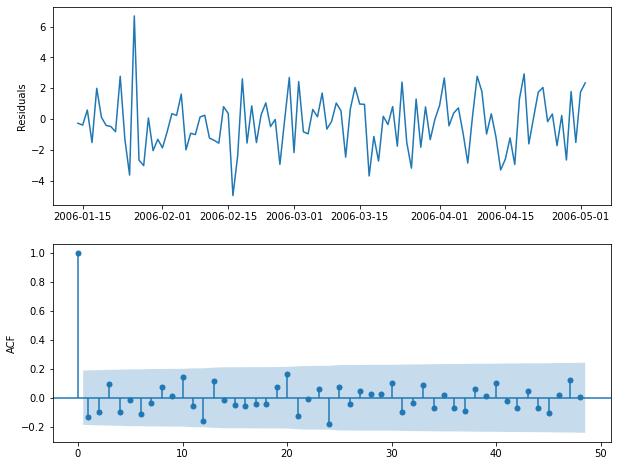

In [304]:
# residuals
plt.figure(figsize=(10,8))
ax = plt.subplot(211)
plt.plot(best_model_2.resid)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_2.resid.squeeze(), lags=48, ax=ax, title=None)
plt.ylabel('ACF')


print("Student test: p=%f" % scipy.stats.ttest_1samp(best_model_2.resid, 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model_2.resid)[1])

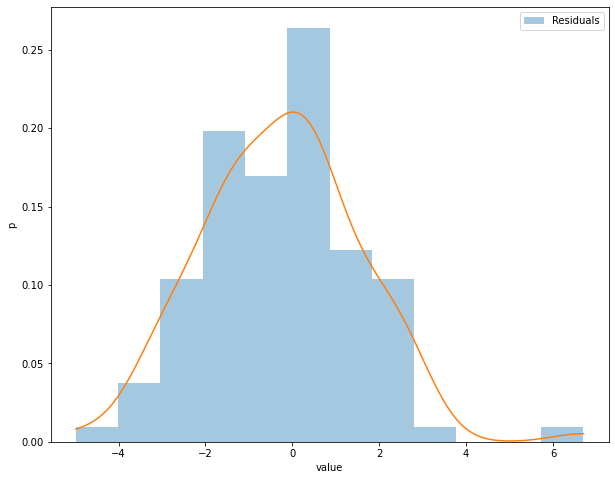

In [113]:
plt.figure(figsize=(10, 8))
d = best_model_2.resid
kernel = scipy.stats.gaussian_kde(d)
min_amount, max_amount = d.min(), d.max()
x = np.linspace(min_amount, max_amount, len(d))
kde_values = kernel(x)

sns.distplot(d, kde=False, norm_hist=True, label="Residuals")
plt.plot(x, kde_values)

plt.ylabel('p')
plt.xlabel('value')

plt.legend()
plt.show()

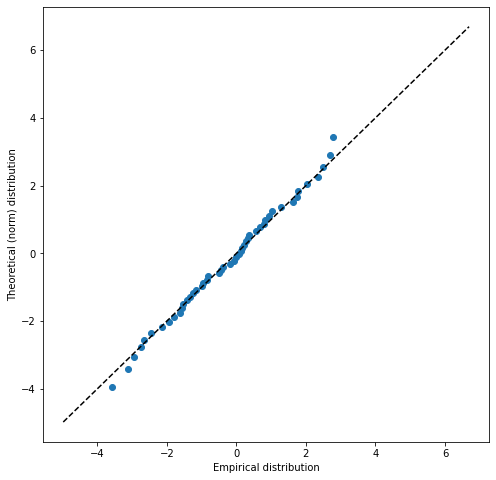

In [114]:
import scipy
params = scipy.stats.norm.fit(best_model_2.resid)
x = np.linspace( np.min(best_model_2.resid), np.max(best_model_2.resid))

percs = np.linspace(0, 100)
qn_first = np.percentile(best_model_2.resid, percs)
qn_gamma = scipy.stats.norm.ppf(percs / 100.0, *params)

# Building a quantile biplot
plt.figure(figsize=(8, 8))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

In [115]:
scipy.stats.shapiro(best_model_2.resid)

ShapiroResult(statistic=0.9819486737251282, pvalue=0.14681784808635712)

## SARIMAX - Temperature (Gaussian filter)

In [323]:
from itertools import product

ps = range(0, 8)
d=1
qs = range(0, 8)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
print (u"Models to analyse by AIC:", len(parameters_list))

[(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (0, 2, 0, 0), (0, 2, 1, 0), (0, 3, 0, 0), (0, 3, 1, 0), (0, 4, 0, 0), (0, 4, 1, 0), (0, 5, 0, 0), (0, 5, 1, 0), (0, 6, 0, 0), (0, 6, 1, 0), (0, 7, 0, 0), (0, 7, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0), (1, 2, 0, 0), (1, 2, 1, 0), (1, 3, 0, 0), (1, 3, 1, 0), (1, 4, 0, 0), (1, 4, 1, 0), (1, 5, 0, 0), (1, 5, 1, 0), (1, 6, 0, 0), (1, 6, 1, 0), (1, 7, 0, 0), (1, 7, 1, 0), (2, 0, 0, 0), (2, 0, 1, 0), (2, 1, 0, 0), (2, 1, 1, 0), (2, 2, 0, 0), (2, 2, 1, 0), (2, 3, 0, 0), (2, 3, 1, 0), (2, 4, 0, 0), (2, 4, 1, 0), (2, 5, 0, 0), (2, 5, 1, 0), (2, 6, 0, 0), (2, 6, 1, 0), (2, 7, 0, 0), (2, 7, 1, 0), (3, 0, 0, 0), (3, 0, 1, 0), (3, 1, 0, 0), (3, 1, 1, 0), (3, 2, 0, 0), (3, 2, 1, 0), (3, 3, 0, 0), (3, 3, 1, 0), (3, 4, 0, 0), (3, 4, 1, 0), (3, 5, 0, 0), (3, 5, 1, 0), (3, 6, 0, 0), (3, 6, 1, 0), (3, 7, 0, 0), (3, 7, 1, 0), (4, 0, 0, 0), (4, 0, 1, 0), (4, 1, 0, 0), (4, 1, 1, 0), (4, 2, 0, 0), (4, 2, 1, 0), (4, 3, 0, 0), (4, 3

In [327]:
y=smoothed_gaussian_1.predict

test_size=10
y_train=y[: -test_size]
y_test=y[-test_size :]

In [325]:
y=smoothed_gaussian_1.predict

test_size=10
y_train=y[: -test_size]
y_test=y[-test_size :]

# ignore warnings 
results = []
best_aic = float("inf")

warnings.filterwarnings('ignore')
i=0
for param in parameters_list:
    print(i)
    i=i+1
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(y_train, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        print("error")
        continue 
    #except LinAlgError:
    #        continue
    aic = model.aic

    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [292]:
result_table_g = pd.DataFrame(results)
result_table_g.columns = ['parameters', 'aic']
print(result_table_g.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
111  (6, 7, 1, 0) -225.832735
123  (7, 5, 1, 0) -225.400073
121  (7, 4, 1, 0) -223.588825
61   (3, 6, 1, 0) -221.231484
105  (6, 4, 1, 0) -213.583085


In [293]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  122
Model:             SARIMAX(6, 1, 7)x(1, 1, [], 12)   Log Likelihood                 127.916
Date:                             Sun, 28 Nov 2021   AIC                           -225.833
Time:                                     19:24:50   BIC                           -185.463
Sample:                                          0   HQIC                          -209.461
                                             - 122                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          3.5566      0.249     14.284      0.000       3.069       4.045
ar.L2         -6.5201      

Text(0.5, 0, 'Date')

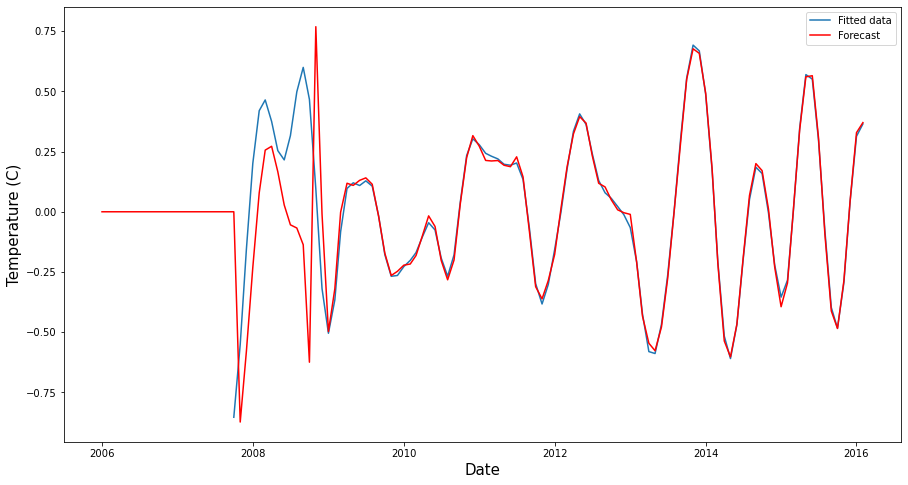

In [329]:
plt.figure(figsize=(15,8))
plt.plot(df_daily['Date'][:-10],y_train, label='Fitted data')
plt.plot(df_daily['Date'][:-10], best_model.predict(start=0,end=len(y_train)-1), color='r', label='Forecast')
plt.legend()
plt.ylabel('Temperature (C)',fontsize=15)
plt.xlabel('Date',fontsize=15)

Text(0.5, 0, 'Date')

<Figure size 1440x720 with 0 Axes>

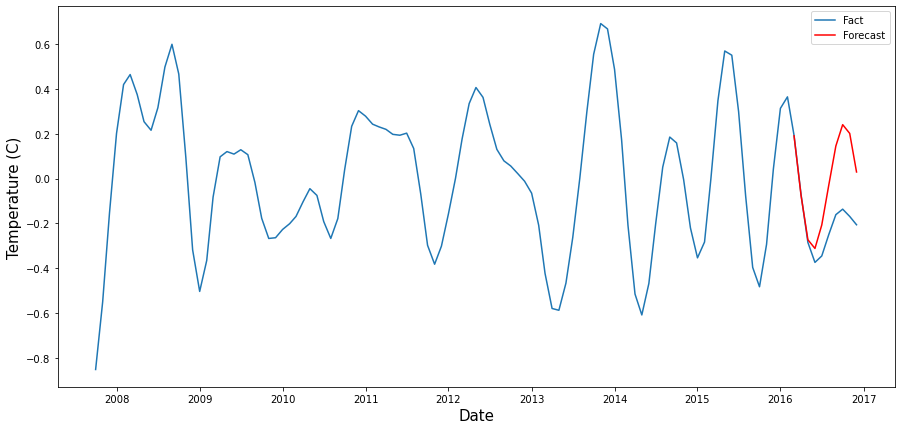

In [245]:
plt.figure(figsize=(20,10))
a= df_daily['Temperature (C)'].shift(1)
b=  df_daily['Temperature (C)'].shift(12)
forecast = best_model.forecast(steps=10)
plt.figure(figsize=(15,7))
plt.plot( df_daily['Date'],y, label='Fact')  
plt.plot( df_daily['Date'][-10:],forecast, color='r', label='Forecast')
plt.legend()
plt.ylabel('Temperature (C)', fontsize=15);
plt.xlabel('Date',fontsize=15)

In [330]:

forecast = best_model.forecast(steps=10)
test_accuracy = y[-10:]
print("MSE = ", mean_squared_error(test_accuracy, forecast ))
print("MAE = ", mean_absolute_error(test_accuracy, forecast ))
print("MAPE = ", round(np.mean(np.abs((test_accuracy-forecast) /test_accuracy))*100,3))

MSE =  0.05016783415904642
MAE =  0.17304882294573404
MAPE =  95.406


In [260]:
forecast

array([ 0.19047328, -0.07685639, -0.27360436, -0.31244449, -0.20761148,
       -0.02868815,  0.14520812,  0.2405377 ,  0.20130776,  0.02913437])

In [261]:
y[-10:]

array([ 0.19261775, -0.07317018, -0.28576259, -0.37474496, -0.34594976,
       -0.24989279, -0.1615118 , -0.13692465, -0.1693899 , -0.20664164])

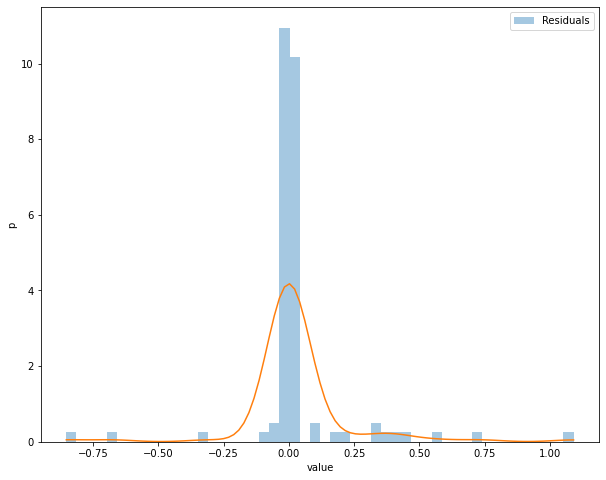

In [221]:
plt.figure(figsize=(10, 8))
d = best_model.resid
d=d[~np.isnan(d)]
kernel = scipy.stats.gaussian_kde(d)
min_amount, max_amount = d.min(), d.max()
x = np.linspace(min_amount, max_amount, len(d))
kde_values = kernel(x)

sns.distplot(d, kde=False, norm_hist=True, label="Residuals")
plt.plot(x, kde_values)

plt.ylabel('p')
plt.xlabel('value')

plt.legend()
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x2c8a585eaf0>,
 'caps': [<matplotlib.lines.Line2D at 0x2c8a585edf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c8a585e730>],
 'medians': [<matplotlib.lines.Line2D at 0x2c8aca81a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c8aca81280>],
 'means': []}

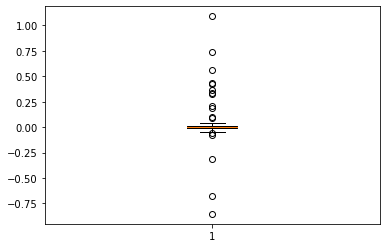

In [251]:
plt.boxplot(d)

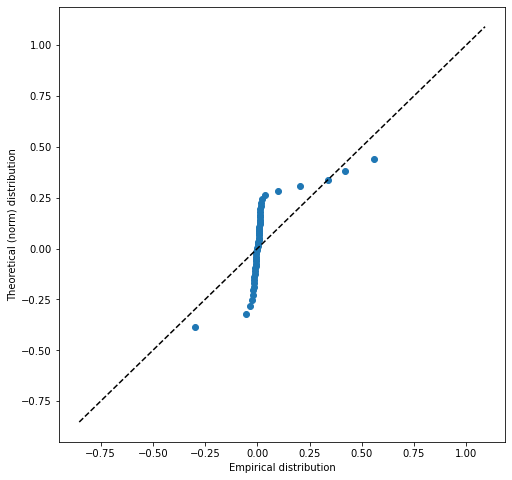

In [225]:
import scipy
params = scipy.stats.norm.fit(d)
x = np.linspace( np.min(d), np.max(d))

percs = np.linspace(0, 100)
qn_first = np.percentile(d,percs)
qn_gamma = scipy.stats.norm.ppf(percs / 100.0, *params)

# Building a quantile biplot
plt.figure(figsize=(8, 8))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

## SARIMAX - Visibility (Gaussian filter)

In [333]:
from itertools import product

ps = range(0, 8)
d=1
qs = range(0, 8)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
print (u"Models to analyse by AIC:", len(parameters_list))

[(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (0, 2, 0, 0), (0, 2, 1, 0), (0, 3, 0, 0), (0, 3, 1, 0), (0, 4, 0, 0), (0, 4, 1, 0), (0, 5, 0, 0), (0, 5, 1, 0), (0, 6, 0, 0), (0, 6, 1, 0), (0, 7, 0, 0), (0, 7, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0), (1, 2, 0, 0), (1, 2, 1, 0), (1, 3, 0, 0), (1, 3, 1, 0), (1, 4, 0, 0), (1, 4, 1, 0), (1, 5, 0, 0), (1, 5, 1, 0), (1, 6, 0, 0), (1, 6, 1, 0), (1, 7, 0, 0), (1, 7, 1, 0), (2, 0, 0, 0), (2, 0, 1, 0), (2, 1, 0, 0), (2, 1, 1, 0), (2, 2, 0, 0), (2, 2, 1, 0), (2, 3, 0, 0), (2, 3, 1, 0), (2, 4, 0, 0), (2, 4, 1, 0), (2, 5, 0, 0), (2, 5, 1, 0), (2, 6, 0, 0), (2, 6, 1, 0), (2, 7, 0, 0), (2, 7, 1, 0), (3, 0, 0, 0), (3, 0, 1, 0), (3, 1, 0, 0), (3, 1, 1, 0), (3, 2, 0, 0), (3, 2, 1, 0), (3, 3, 0, 0), (3, 3, 1, 0), (3, 4, 0, 0), (3, 4, 1, 0), (3, 5, 0, 0), (3, 5, 1, 0), (3, 6, 0, 0), (3, 6, 1, 0), (3, 7, 0, 0), (3, 7, 1, 0), (4, 0, 0, 0), (4, 0, 1, 0), (4, 1, 0, 0), (4, 1, 1, 0), (4, 2, 0, 0), (4, 2, 1, 0), (4, 3, 0, 0), (4, 3

In [334]:
y=smoothed_gaussian_2.predict

test_size=10
y_train=y[: -test_size]
y_test=y[-test_size :]

# ignore warnings 
results = []
best_aic = float("inf")

warnings.filterwarnings('ignore')
i=0
for param in parameters_list:
    print(i)
    i=i+1
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(y_train, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        print("error")
        continue 
    #except LinAlgError:
    #        continue
    aic = model.aic

    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [275]:
result_table_g2 = pd.DataFrame(results)
result_table_g2.columns = ['parameters', 'aic']
print(result_table_g2.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
29   (1, 6, 1, 0) -328.079878
47   (2, 7, 1, 0) -327.600368
95   (5, 7, 1, 0) -324.115244
127  (7, 7, 1, 0) -320.000090
59   (3, 5, 1, 0) -307.477998


In [276]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  122
Model:             SARIMAX(1, 1, 6)x(1, 1, [], 12)   Log Likelihood                 173.040
Date:                             Sun, 28 Nov 2021   AIC                           -328.080
Time:                                     19:03:06   BIC                           -303.858
Sample:                                          0   HQIC                          -318.257
                                             - 122                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7393      0.122      6.056      0.000       0.500       0.979
ma.L1          2.8221      

Text(0.5, 0, 'Date')

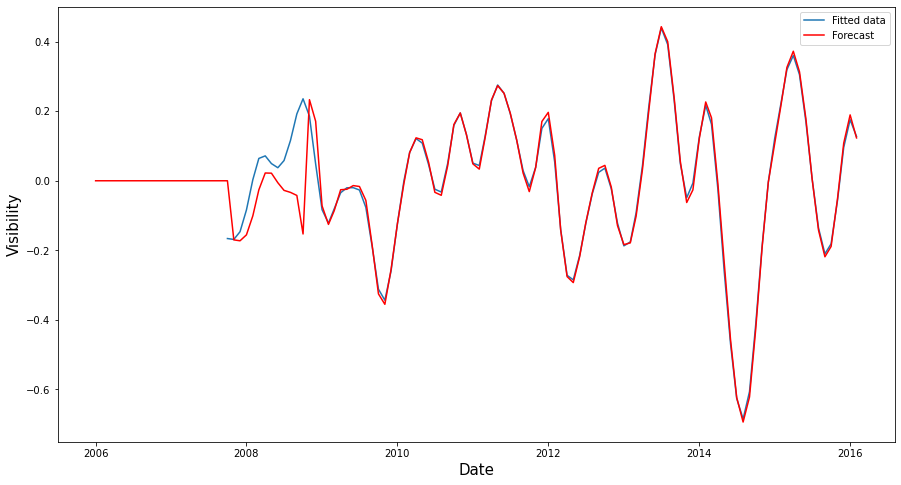

In [279]:
plt.figure(figsize=(15,8))
plt.plot(df_daily['Date'][:-10],y_train, label='Fitted data')
plt.plot(df_daily['Date'][:-10], best_model.predict(start=0,end=len(y_train)-1), color='r', label='Forecast')
plt.legend()
plt.ylabel('Visibility',fontsize=15)
plt.xlabel('Date',fontsize=15)

Text(0.5, 0, 'Date')

<Figure size 1440x720 with 0 Axes>

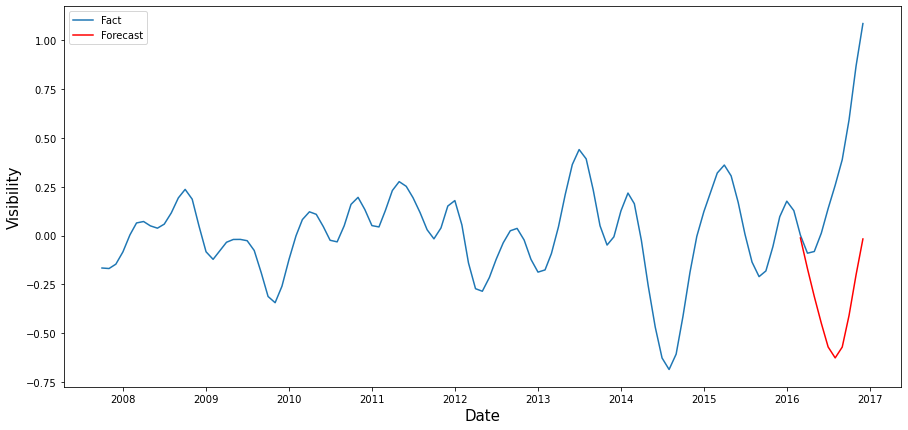

In [280]:
plt.figure(figsize=(20,10))
a= df_daily['Temperature (C)'].shift(1)
b=  df_daily['Temperature (C)'].shift(12)
forecast = best_model.forecast(steps=10)
plt.figure(figsize=(15,7))
plt.plot( df_daily['Date'],y, label='Fact')  
plt.plot( df_daily['Date'][-10:],forecast, color='r', label='Forecast')
plt.legend()
plt.ylabel('Visibility', fontsize=15);
plt.xlabel('Date',fontsize=15)

In [336]:
forecast = best_model.forecast(steps=10)
test_accuracy = y[-10:]
print("MSE = ", mean_squared_error(test_accuracy, forecast ))
print("MAE = ", mean_absolute_error(test_accuracy, forecast ))
print("MAPE = ", round(np.mean(np.abs((test_accuracy-forecast) /test_accuracy))*100,3))

MSE =  0.5815737680380142
MAE =  0.649767205910394
MAPE =  658.327


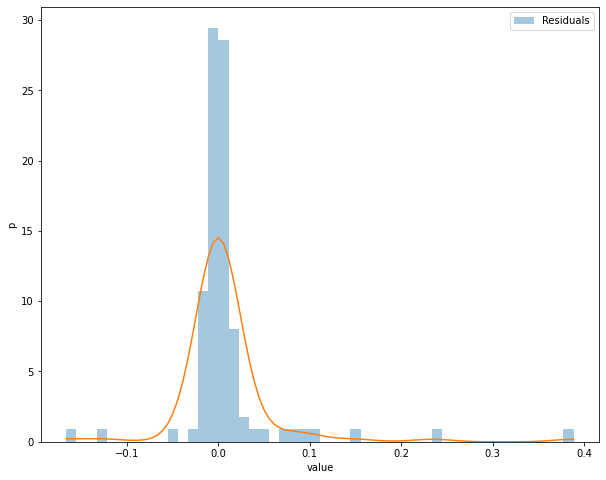

In [286]:
plt.figure(figsize=(10, 8))
d = best_model.resid
d=d[~np.isnan(d)]
kernel = scipy.stats.gaussian_kde(d)
min_amount, max_amount = d.min(), d.max()
x = np.linspace(min_amount, max_amount, len(d))
kde_values = kernel(x)

sns.distplot(d, kde=False, norm_hist=True, label="Residuals")
plt.plot(x, kde_values)

plt.ylabel('p')
plt.xlabel('value')

plt.legend()
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x2c8b13ff280>,
 'caps': [<matplotlib.lines.Line2D at 0x2c8b13ff970>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c8b13efee0>],
 'medians': [<matplotlib.lines.Line2D at 0x2c8b140c070>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c8b140c3d0>],
 'means': []}

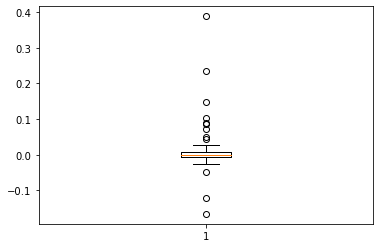

In [287]:
plt.boxplot(d)

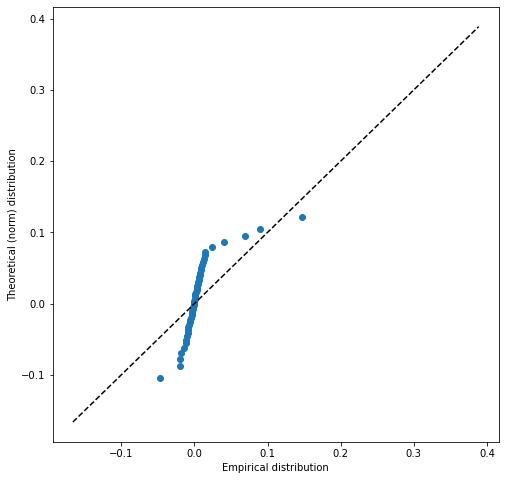

In [288]:
import scipy
params = scipy.stats.norm.fit(d)
x = np.linspace( np.min(d), np.max(d))

percs = np.linspace(0, 100)
qn_first = np.percentile(d,percs)
qn_gamma = scipy.stats.norm.ppf(percs / 100.0, *params)

# Building a quantile biplot
plt.figure(figsize=(8, 8))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

# Build model in a form of linear dynamical system, using chosen predictors. To analyze residual error and to define appropriate order of model.